In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

## Prepare data

In [19]:
#load data
print('Loading data...')
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

Loading data...


In [20]:
#preprocess data
X = train.drop(['id','species'],axis=1)

#encode target labels
encoder = LabelEncoder()
y = encoder.fit_transform(train.species)

In [21]:
species = list(train.species.unique())

In [22]:
#prepare data for cross-validation
seed = 7

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, 
                                                                    y, 
                                                                    test_size=0.2, 
                                                                    random_state=seed,
                                                                    stratify=y) #stratified to ensure equal class representation

## Experiment with different models

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [24]:
import warnings
warnings.simplefilter("ignore", UserWarning)

In [25]:
def testing_harness(X, y, k=10, subtitle='', chart=False):
    # evaluate each model in turn
    
    results = []
    names = []
    scoring = 'accuracy'
    
    # prepare models
    models = []

    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier(n_estimators=100)))
    models.append(('AdaBoost',AdaBoostClassifier()))
    #models.append(('GradientBoost',GradientBoostingClassifier()))
    models.append(('NB', GaussianNB()))
    #models.append(('SVM', SVC(kernel="rbf", C=0.025, probability=True)))
    
    print('Cross-Validation Results:', subtitle)
    print('='*30)
    print('Model: mean (stdev)')
    print('='*30)

    #Test the performance of each model against the data, using cross-validation
    for name, model in models:
        kfold = model_selection.KFold(n_splits=k, random_state=seed) #prepare K-fold CV
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring) #cross-validate model using K-fold CV
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

    print('='*30)

    
    df = pd.DataFrame(results, names).T
    
    ## visualize results
    if chart:
        
        summary = df.mean(axis=0).sort_values(ascending=False)
        order = list(summary.index)
        df = df[order]

        viz = df.plot(kind='box',
                title='Algorithm Comparison',
                     figsize=(15,7.5))
        viz.set_ylabel('Accuracy')
    
    return df
    

Cross-Validation Results: 
Model: mean (stdev)
LR: 0.186772 (0.044575)
LDA: 0.970934 (0.017968)
KNN: 0.796820 (0.039763)
CART: 0.588402 (0.045121)
RF: 0.963323 (0.018320)
AdaBoost: 0.021487 (0.017023)
NB: 0.464731 (0.047658)


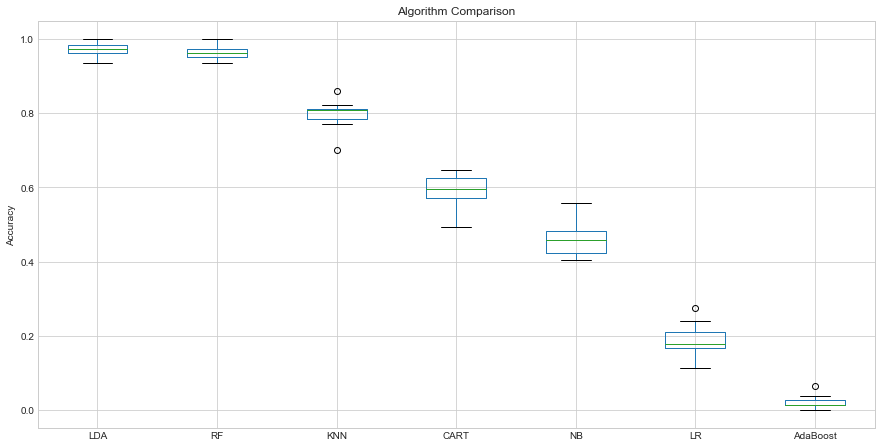

In [26]:
results = testing_harness(X_train, y_train)

Linear Discriminant Analysis and Random Forest are competitive with each other in the high .9s; the rest have mixed performance.

Let's try standardizing our feature set.

In [27]:
#standardize feature set
scaler = StandardScaler()
scaler.fit(X) #fit on entire feature set

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [28]:
results_std = testing_harness(X_train_std, y_train, subtitle='w/ Standardized')

Cross-Validation Results: w/ Standardized
Model: mean (stdev)
LR: 0.965854 (0.013973)
LDA: 0.970934 (0.017968)
KNN: 0.957009 (0.018137)
CART: 0.595918 (0.038309)
RF: 0.963370 (0.020738)
AdaBoost: 0.021487 (0.017023)
NB: 0.462199 (0.049708)


In [29]:
def prep(data):
    data = data.T
    
    test = []
    for i in range(0,10):
        test.append(data[i])

    data = pd.concat(test)
    data = pd.DataFrame(data, columns=['accuracy'])
    return data
    

In [30]:
res = prep(results)
res['name'] = 'Baseline'
res = res.reset_index()

res_std= prep(results_std)
res_std['name'] = 'Standardized'
res_std = res_std.reset_index()

results_ = pd.concat([res, res_std])

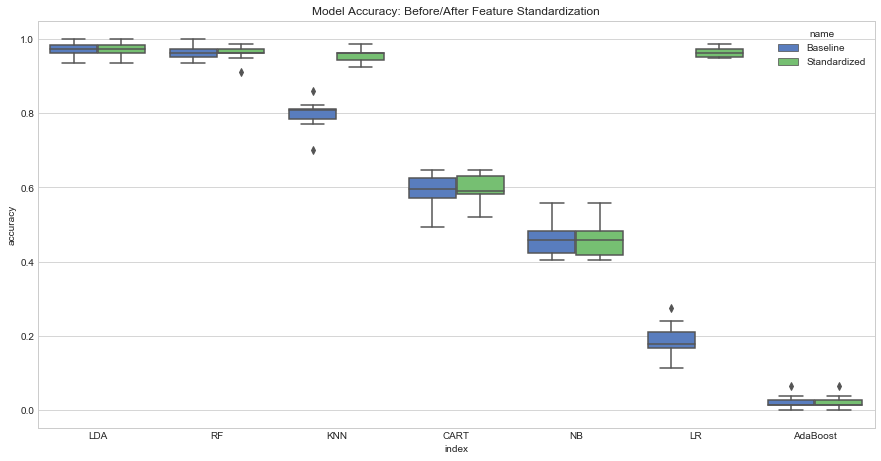

In [32]:
fig, ax = plt.subplots(figsize=(15,7.5))

sns.boxplot(x='index',y='accuracy',data=results_, hue="name", palette='muted',ax=ax)
ax.set_title('Model Accuracy: Before/After Feature Standardization')

Most of the models benefitted from standardizing the dataset, but Logistic Regression experienced significant gains in accuracy.  

We will take a deeper look at the top three models: Random Forest, Linear Discriminant Analysis, and Logistic Regression.

#### Logistic Regression

In [33]:
clf = LogisticRegression(n_jobs=2)

param_grid = {
    'penalty': ['l1','l2'],
    'C': [0.001 , 0.01 , 0.1 , 1 , 10, 100]
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_std, y_train)

parems = CV_rfc.best_params_

print('='*30)
print(clf.__class__.__name__)
print(parems)

LR = LogisticRegression(n_jobs=2, penalty=parems['penalty'], C=parems['C'])
LR.fit(X_train_std, y_train)
preds = LR.predict(X_test_std)
accuracy = sum(preds == y_test) / len(y_test)
print('Accuracy:', accuracy)
print('='*30)

LogisticRegression
{'C': 10, 'penalty': 'l2'}
Accuracy: 0.969696969697


#### Random Forest

In [34]:
clf = RandomForestClassifier(n_jobs=2, n_estimators=100) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_std, y_train)

parems = CV_rfc.best_params_

print('='*30)
print(clf.__class__.__name__)
print(parems)

RF = RandomForestClassifier(n_jobs=2, max_features= parems['max_features'] ,n_estimators=parems['n_estimators'])
RF.fit(X_train_std, y_train)
preds = RF.predict(X_test_std)
accuracy = sum(preds == y_test) / len(y_test)
print('Accuracy:', accuracy)
print('='*30)

RandomForestClassifier
{'max_features': 'sqrt', 'n_estimators': 700}
Accuracy: 0.979797979798


#### Linear Discriminant Analysis

In [35]:
clf = LinearDiscriminantAnalysis()

param_grid = {
    'solver': ['svd','lsqr','eigen']
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_std, y_train)

parems = CV_rfc.best_params_

print('='*30)
print(clf.__class__.__name__)
print(parems)

LDA = LinearDiscriminantAnalysis(solver=parems['solver'])
LDA.fit(X_train_std, y_train)
preds = LDA.predict(X_test_std)
accuracy = sum(preds == y_test) / len(y_test)
print('Accuracy:', accuracy)
print('='*30)

LinearDiscriminantAnalysis
{'solver': 'svd'}
Accuracy: 0.979797979798


Random Forest and LDA have about the same accuracy, and both slightly out-perform Logistic Regression.

### PCA Analysis

In [36]:
#standardize feature set
scaler = StandardScaler()

#fit on entire feature set
X_std = scaler.fit_transform(X)

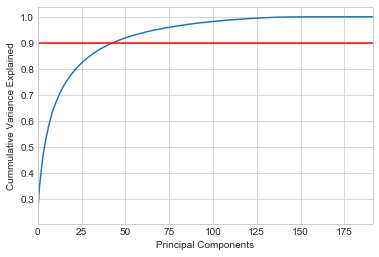

In [37]:
pca = PCA()
pca.fit_transform(X_std)

viz = pd.Series(pca.explained_variance_ratio_.cumsum()).plot()
#viz.set_title('Cumulative Variance Explained')
viz.set_ylabel('Cummulative Variance Explained')
viz.set_xlabel('Principal Components')
viz.axhline(y=.9,c='r') #k threshold at 90%

In [38]:
pca = PCA(n_components=44)
X_reduced = pca.fit_transform(X_std)

In [39]:
#prepare data for cross-validation
seed = 7

Xpca_train, Xpca_test, ypca_train, ypca_test = model_selection.train_test_split(X_reduced, 
                                                                                y,
                                                                                test_size=0.2,
                                                                                random_state=seed,
                                                                                stratify=y) #stratified to ensure equal class representation

In [40]:
clf = RandomForestClassifier(n_jobs=2, n_estimators=100) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(Xpca_train, ypca_train)

parems = CV_rfc.best_params_
print('='*30)
print(clf.__class__.__name__)
print(parems)

RF = RandomForestClassifier(n_jobs=2, max_features= parems['max_features'] ,n_estimators=parems['n_estimators'])
RF.fit(Xpca_train, ypca_train)
preds = RF.predict(Xpca_test)
accuracy = sum(preds == ypca_test) / len(ypca_test)
print('Accuracy:', accuracy)
print('='*30)

RandomForestClassifier
{'max_features': 'auto', 'n_estimators': 200}
Accuracy: 0.984848484848


In [41]:
clf = LinearDiscriminantAnalysis()

param_grid = {
    'solver': ['svd','lsqr','eigen']
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(Xpca_train, ypca_train)

parems = CV_rfc.best_params_

print('='*30)
print(clf.__class__.__name__)
print(parems)

LDA = LinearDiscriminantAnalysis(solver=parems['solver'])
LDA.fit(Xpca_train, ypca_train)
preds = LDA.predict(Xpca_test)
accuracy = sum(preds == ypca_test) / len(ypca_test)
print('Accuracy:', accuracy)
print('='*30)

LinearDiscriminantAnalysis
{'solver': 'svd'}
Accuracy: 0.979797979798


PCA on its own yielded no extra accuracy. Let's try it with the original features.

In [42]:
df = pd.concat([pd.DataFrame(X_std),pd.DataFrame(X_reduced)], axis=1)

In [43]:
#prepare data for cross-validation
seed = 7

XX_train, XX_test, yy_train, yy_test = model_selection.train_test_split(df, 
                                                                                y,
                                                                                test_size=0.2,
                                                                                random_state=seed,
                                                                                stratify=y) #stratified to ensure equal class representation

In [44]:
clf = RandomForestClassifier(n_jobs=2, n_estimators=100) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}

CV_rfc = GridSearchCV(estimator=clf, param_grid=param_grid, cv= 5)
CV_rfc.fit(XX_train, yy_train)

parems = CV_rfc.best_params_

print('='*30)
print(clf.__class__.__name__)
print(parems)

RF = RandomForestClassifier(n_jobs=2, max_features= parems['max_features'] ,n_estimators=parems['n_estimators'])
RF.fit(XX_train, yy_train)
preds = RF.predict(XX_test)
accuracy = sum(preds == yy_test) / len(yy_test)
print('Accuracy:', accuracy)
print('='*30)

RandomForestClassifier
{'max_features': 'log2', 'n_estimators': 700}
Accuracy: 0.984848484848


Adding the Principal Components as new features to the standardized original dataset led to a small increase in accuracy.

Let's make a prediction.

In [ ]:
#preprocess data
X_Test = test.drop(['id'],axis=1)
ids = test['id']

In [ ]:
#standardize feature set
scaler = StandardScaler()
X_Test= scaler.fit_transform(X_Test)

In [ ]:
pca = PCA(n_components=44)
X_Test_pca = pca.fit_transform(X_Test)

In [ ]:
df_test = pd.concat([pd.DataFrame(X_Test),pd.DataFrame(X_Test_pca)], axis=1)

In [ ]:
RF = RandomForestClassifier(n_jobs=2, max_features= parems['max_features'] ,n_estimators=parems['n_estimators'])
RF.fit(df, y)
preds = RF.predict(df_test)
pred_prob = RF.predict_proba(df_test)

In [ ]:
result = pd.concat([pd.Series(ids), pd.DataFrame(pred_prob)], axis=1)
result = result.set_index('id')
result.columns = species
result.head()

In [33]:
from time import localtime, strftime
t = strftime("%Y_%m_%d_%H_%M_%S", localtime())
filename = 'results_'+t+'.csv'

result.to_csv(filename)